# Model fitting

A key component of computational modeling is estimating the values of the parameters that best describe your behavioral data. While there are a number of different ways of estimating parameters, here we focus on the maximum-likelihood approach, although almost all of our points apply to other methods such as Markov Chain Monte Carlo approaches (e.g. Lee and Wagenmakers 2014). Mathematical details, as well as additional discussion of other approaches to model fitting can be found in the Appendix of (Wilson and Collins 2019).

In the maximum likelihood approach to model fitting, our goal is to find the parameter values of model $m$, $\hat{\theta}_m^{MLE}$, that maximize the likelihood of the data, $d_{1:T}$, given the parameters, $p(d_{1:T} | \theta_m, m)$. Maximizing the likelihood is equivalent to maximizing the log of the likelihood,  $LL = \log p(d_{1:T} | \theta_m, m)$, which is numerically more tractable. A simple mathematical derivation shows that this log-likelihood can be written in terms of the choice probabilities of the individual model as
\begin{equation}
\label{eq:LL}
	LL = \log p(d_{1:T} | \theta_m, m) 
	= \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, \theta_m, m)
\end{equation}
where $p(c_t | d_{1:t-1}, s_t, \theta_m, m)$ is the probability of each individual choice given the parameters of the model and available information up to that choice, which is at the heart of the definition of each model. 


## Computing the log likelihood

In practice, the likelihood is simply a function of the data and parameters that we can define in Matlab for each of the models under consideration. In this notebook we will focus on the Model 3, the Rescorla Wagner model. For this model, we can write a likelihood function as:

In [1]:
%%file lik_M3RescorlaWagner_v1.m

function NegLL = lik_M3RescorlaWagner_v1(a, r, alpha, beta)

Q = [0.5 0.5];

T = length(a);

% loop over all trial
for t = 1:T
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % compute choice probability for actual choice
    choiceProb(t) = p(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end

% compute negative log-likelihood
NegLL = -sum(log(choiceProb));

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/lik_M3RescorlaWagner_v1.m'.


Note that the output of this function is the negative of the log-likelihood not the true log likelihood. This is because Matlab's optimization algorithms are setup to minimize functions not maximize them. Obviously minimizing the negative log-likelihood is the same as maximizing the log-likelihood.

Note also the similarity between the code for the likelihood function and the code for simulating the same model (see below). Choice probabilities and values are computed in exactly the same way. The only difference is that the simulation function samples choices and rewards while the likelihood function takes choices and rewards as inputs and computes the probability that each choice was made for given parameter values.

In [2]:
%%file simulate_M3RescorlaWagner_v1.m

function [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta)

Q = [0.5 0.5];

for t = 1:T
    
    % compute choice probabilities
    p = exp(beta*Q) / sum(exp(beta*Q));
    
    % make choice according to choice probababilities
    a(t) = choose(p);
    
    % generate reward based on choice
    r(t) = rand < mu(a(t));
    
    % update values
    delta = r(t) - Q(a(t));
    Q(a(t)) = Q(a(t)) + alpha * delta;

end



Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/simulate_M3RescorlaWagner_v1.m'.


We can now use the log-likelihood function to compute the (negative) log-likelihood for some simulated choices

In [3]:
% simulate choices from Model 3
T = 50;
mu = [0.2 0.8];
alpha = 0.1;
beta = 5;
[a, r] = simulate_M3RescorlaWagner_v1(50, mu, alpha, beta);

% evaluate negative log-likelihood for this simulated dataset at some other parameter values
alpha_hat = 0.2;
beta_hat = 10;
NegLL = lik_M3RescorlaWagner_v1(a, r, alpha_hat, beta_hat)


NegLL =

   18.6151



## Fitting 
In principle, finding the maximum likelihood parameters is as 'simple' as maximizing $LL$. In practice, of course, finding the maximum of a function is not a trivial process. The simplest approach, a brute force search of the entire parameter space. Let's try that for our simulated data set.  For simplicity we will assume that we know beta but don't know alpha ...


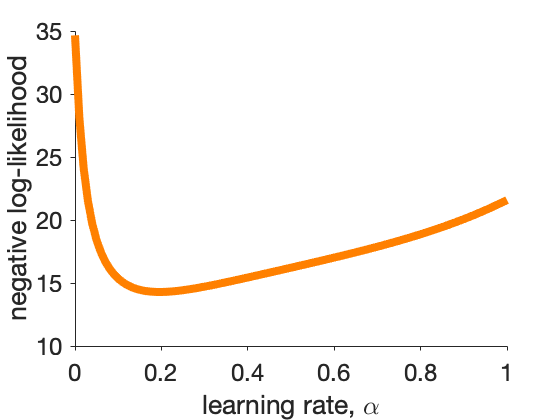

In [4]:
alpha_vals = [0:0.01:1];
for i = 1:length(alpha_vals)
    nLL(i) = lik_M3RescorlaWagner_v1(a, r, alpha_vals(i), beta);
end

plot(alpha_vals, nLL, 'linewidth', 6, 'color', [1 0.5 0]);
set(gca, 'box', 'off', 'fontsize', 18, 'tickdir', 'out')
xlabel('learning rate, \alpha')
ylabel('negative log-likelihood')

Unfortunately, the brute force approach is unfeasible outside of the simplest cases (e.g. one or two parameters with tight bounds) due to the high computational costs of evaluating the likelihood function at a large number of points. 

Fortunately, a number of tools exist for finding local maxima (and minima) of functions quickly using variations on gradient ascent (or descent). For example, Matlab's fmincon function can use a variety of sophisticated optimization algorithms to find the minimum of a function. So long as one remembers to feed fmincon the negative log-likelihood, using tools such as fmincon can greatly speed up model fitting. 

In practice, in many cases using fmincon for fitting model parameters comes down to five lines of code specifying: (1) the function you wish to minimize, (2) the starting values of the parameters for the search algorithm, (3) the lower bounds for each parameter, (4) the upper bounds for each parameter, and (5) the call to fmincon.  

For Model 3, this plays out as:


In [5]:
% define a function handle for the likelihood function 
obFunc = @(x) lik_M3RescorlaWagner_v1(a, r, x(1), x(2));

% define the initial conditions for the parameter search
X0 = [rand exprnd(1)];

% lower bounds for parameters
LB = [0 0];

% upper bounds for parameters
UB = [1 inf];

% call fmincon to get fit parameters and NegLL at minimum
[Xfit, NegLL] = fmincon(obFunc, X0, [], [], [], [], LB, UB)



Local minimum found that satisfies the constraints.

Optimization completed because the objective function is non-decreasing in 
feasible directions, to within the value of the optimality tolerance,
and constraints are satisfied to within the value of the constraint tolerance.


Xfit =

    0.2303    4.5067


NegLL =

   14.2629



## Parameter recovery
Before reading too much into the best fitting parameter values, $\theta_m^{MLE}$, it is important to check whether the fitting procedure gives meaningful parameter values in the best case scenario - i.e. when fitting fake data where the 'true' parameter values are known. Such a procedure is known as 'Parameter Recovery,' and is a crucial part of any model-based analysis.  

In principle, the recipe for parameter recovery is quite simple. First, simulate fake data with known parameter values. Next, fit the model to this fake data to try to 'recover' the parameters. Finally, compare the recovered parameters to their true values. In a perfect world the simulated and recovered parameters will be tightly correlated, with no bias. If there is only a weak correlation between simulated and recovered parameters and/or a significant bias, then this is an indication that there is either a bug in your code (often the case) or the experiment is underpowered to assess this model (also often the case!).

In [6]:
%%file fit_M3RescorlaWagner_v1.m

% To make parameter recovery code simpler to read define a function for fitting Model 3

function [Xfit, LL, BIC] = fit_M3RescorlaWagner_v1(a, r)

obFunc = @(x) lik_M3RescorlaWagner_v1(a, r, x(1), x(2));

X0 = [rand exprnd(1)];
LB = [0 0];
UB = [1 inf];

options = optimoptions('fmincon','Display','off'); % this turns verbose mode off
[Xfit, NegLL] = fmincon(obFunc, X0, [], [], [], [], LB, UB, [], options);




LL = -NegLL;
BIC = length(X0) * log(length(a)) + 2*NegLL;

Created file '/Users/bob/Work/Teaching/2019_MIND_SummerSchool/notebooks/fit_M3RescorlaWagner_v1.m'.


In [1]:
% experiment parameters
T   = 50;         % number of trials
mu  = [0.2 0.8];    % mean reward of bandits

% Model 3: Rescorla Wagner
for count = 1:100
    alpha = rand;
    beta = exprnd(10);
    [a, r] = simulate_M3RescorlaWagner_v1(T, mu, alpha, beta);
    [Xf, LL, BIC] = fit_M3RescorlaWagner_v1(a, r);
    
    Xsim(1,count) = alpha;
    Xsim(2,count) = beta;
    Xfit(1,count) = Xf(1);
    Xfit(2,count) = Xf(2);
    
end


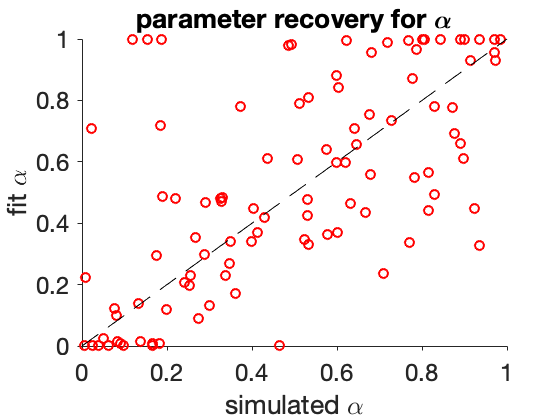

In [2]:
% parameter recovery for alpha
hold on;
plot(Xsim(1,:), Xfit(1,:),'o', 'markersize', 7, 'color', 'r')
plot([0 1], [0 1], 'k--')

xlabel('simulated \alpha'); 
ylabel('fit \alpha'); 
title('parameter recovery for \alpha')
set(gca, 'tickdir','out', 'fontsize', 18)

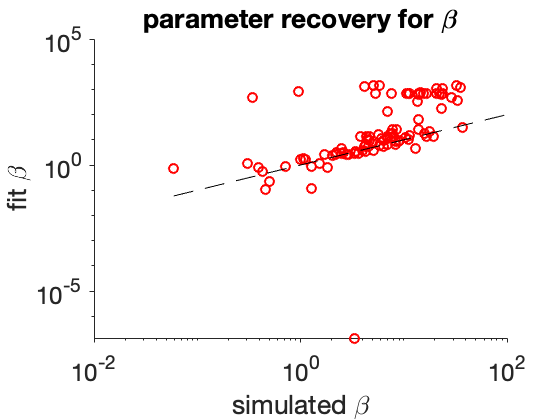

In [3]:
% parameter recovery for beta
hold on;
plot(Xsim(2,:), Xfit(2,:),'o', 'markersize', 7, 'color', 'r')

xlabel('simulated \beta'); 
ylabel('fit \beta'); 
title('parameter recovery for \beta')
set(gca, 'tickdir','out', 'fontsize', 18, 'xscale', 'log', 'yscale', 'log')
xl = get(gca,'xlim');
plot(xl, xl, 'k--')

Is that good parameter recovery?  How can we improve it?